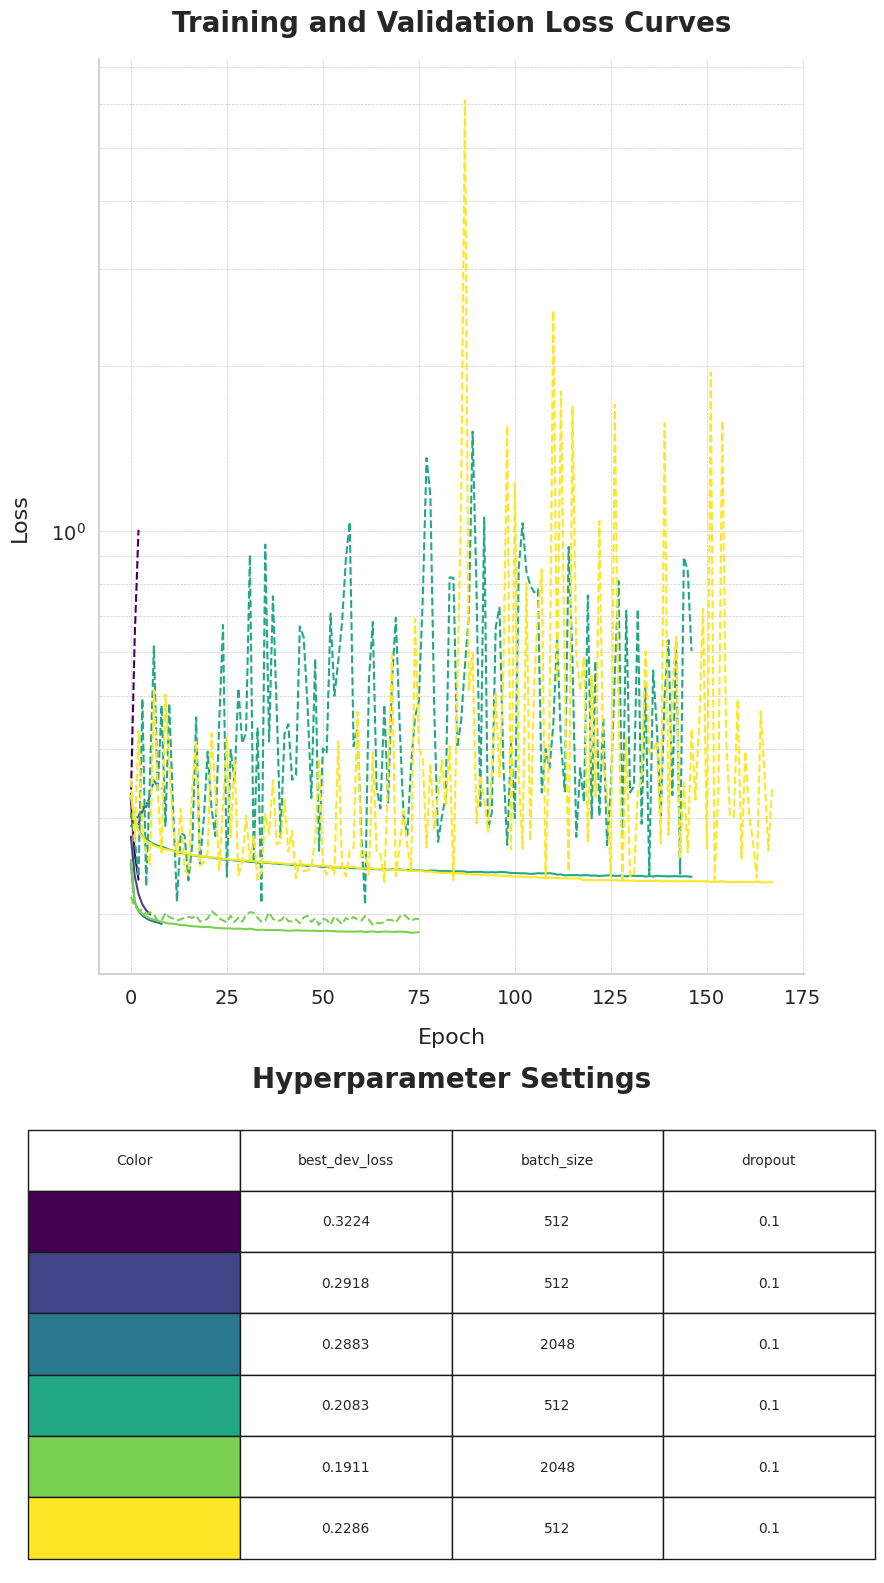

In [10]:
from lib.ekyn import *
from lib.env import *
from sage.utils import *
from sage.models import *
from sklearn.metrics import ConfusionMatrixDisplay,f1_score
import pandas as pd
import os

states = {}

for experiment in os.listdir(f'{EXPERIMENTS_PATH}'):
    if experiment == '.Trash-1000':
        continue
    state = torch.load(f'{EXPERIMENTS_PATH}/{experiment}/state.pt',map_location='cpu',weights_only=False)
    states[experiment] = state

df = pd.DataFrame([states[experiment] for experiment in states])
pd.set_option('display.max_rows', 500)
df = df.sort_values(by='start_time',ascending=False)
df = df.reset_index(drop=True)
# info_df = df[['start_time','sequence_length','best_dev_loss','num_layers','bidirectional','training_stride','dropout','bidirectional','lr','wd','batch_size']]
# display(info_df)
# display(info_df.sort_values(by='best_dev_loss'))
plot_loss_curves(df,moving_window_length=1,lstm=False)

In [3]:
pd.set_option('display.max_columns', 500)
df

,start_time,execution_time,trainlossi,testlossi,best_dev_loss,model,scheduler,criterion,optimizer,best_model_wts,experiment_group_id,wd,lr,batch_size,robust,norm,dropout,stem_kernel_size,widthi,depthi,patience,epochs,device,fold,bidirectional,scheduler_patience,sequence_length,encoder_experiment_name,hidden_size,num_layers,frozen_encoder,early_stopping,best_dev_f1
0,2024_26_08_14_13_14,11.443097,"[0.5163377002616371, 0.32888145415623043, 0.29...","[0.37230116830152626, 0.306242856909247, 0.274...",0.2083,"ResNetv2(\n (stem): Conv1d(1, 4, kernel_size=...",<torch.optim.lr_scheduler.ReduceLROnPlateau ob...,CrossEntropyLoss(),AdamW (\nParameter Group 0\n amsgrad: False...,"{'stem.weight': [[tensor([0.3490, 0.2038, 0.27...",encoder,0.01,0.0003,512,False,batch,0.1,3,"[4, 8, 16]","[2, 2, 2]",100,500,cuda:0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
1,2024_26_08_11_38_35,15.620105,"[0.7180765602063006, 0.251172608864589, 0.2101...","[0.339606374502182, 0.2148057288593716, 0.2067...",0.1911,Dumbledore(\n (encoder): ResNetv2(\n (stem...,<torch.optim.lr_scheduler.ReduceLROnPlateau ob...,CrossEntropyLoss(),AdamW (\nParameter Group 0\n amsgrad: False...,"{'encoder.stem.weight': [[tensor([ 0.5088, -0....",lstm,0.01,0.0003,2048,False,batch,0.1,3,"[4, 8, 16, 32]","[1, 1, 1, 1]",25,500,cuda:0,0,True,20.0,3.0,2024_22_08_17_10_52,64.0,1.0,True,True,0.9027
2,2024_22_08_17_10_52,11.056178,"[0.46395566765608404, 0.329041939897415, 0.297...","[0.3427402692682603, 0.35192406144650545, 0.27...",0.2286,"ResNetv2(\n (stem): Conv1d(1, 4, kernel_size=...",<torch.optim.lr_scheduler.ReduceLROnPlateau ob...,CrossEntropyLoss(),AdamW (\nParameter Group 0\n amsgrad: False...,"{'stem.weight': [[tensor([ 0.5088, -0.2957, 0...",encoder,0.01,0.0003,512,False,batch,0.1,3,"[4, 8, 16]","[2, 2, 2]",100,500,cuda:0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.8628


In [ ]:
from sklearn.model_selection import train_test_split
from lib.ekyn import *

MODEL_ID = f'2024_16_08_12_48_06'

ekyn_ids = get_ekyn_ids()
train_ids,test_ids = train_test_split(ekyn_ids,test_size=.2,shuffle=True,random_state=0)
print(train_ids,test_ids)
state = torch.load(f'{EXPERIMENTS_PATH}/{MODEL_ID}/state.pt',map_location='cpu',weights_only=False)
model = copy.deepcopy(state['model'])
model.load_state_dict(state['best_model_wts'])
trainloader,testloader = get_sequenced_dataloaders(batch_size=state['batch_size'],sequence_length=state['sequence_length'])
# trainloader,testloader = get_epoched_dataloaders(batch_size=state['batch_size'],robust=False)
loss,y_true,y_pred = evaluate(dataloader=testloader,model=model,criterion=state['criterion'],device='cuda')
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true',colorbar=False)
plt.title(f'f1 : {f1_score(y_true,y_pred,average="macro"):.3f}')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

# Assuming df is populated with necessary data
df = {}

# Initialize the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))

# Loop through test IDs
for id in test_ids:
    # Load data and perform necessary calculations
    X, y = load_ekyn_pt(id=id, condition='PF')

    # ECDF plot
    std, mean = torch.std_mean(X[torch.where(y.argmax(axis=1) == 1)[0]], dim=1)
    sns.ecdfplot(std, linewidth=2, label=id, ax=axes[0])

    # Calculate F1 score
    dataloader = get_epoched_dataloader_for_ids(ids=[id],robust=state['robust'])
    loss, y_true, y_pred = evaluate(dataloader=dataloader, model=model, criterion=state['criterion'], device='cuda')
    f1 = float(f1_score(y_true, y_pred, average="macro"))

    # Bar plot
    sns.barplot(x=[id], y=[f1], ax=axes[1])  # Plotting F1 score for each ID


# for id in train_ids:
#     # Load data and perform necessary calculations
#     X, y = load_ekyn_pt(id=id, condition='PF')

#     # ECDF plot
#     std, mean = torch.std_mean(X[torch.where(y.argmax(axis=1) == 1)[0]], dim=1)
#     sns.ecdfplot(std, linewidth=.5, label=id, ax=axes[0],color='black')

# Final adjustments
axes[0].legend()
axes[0].set_xlim([0, .000150])
axes[1].set_ylim([0, 1])  # Adjust y-axis limits for the bar plot

# Display the plot
plt.tight_layout()
plt.show()
